In [6]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
np.random.seed(0)

In [7]:
def geo_to_body(roll, pitch, yaw):
    """
    geographical to body frame transformation matrix generator
    """
    s_phi = np.sin(roll)
    c_phi = np.cos(roll)
    s_theta = np.sin(pitch)
    c_theta = np.cos(pitch)
    s_psi = np.sin(yaw)
    c_psi = np.cos(yaw)
    return np.array([
        [c_psi * c_theta, s_psi * c_theta, -s_theta],
        [c_psi * s_theta * s_phi - s_psi * c_phi, s_psi * s_theta * s_phi + c_psi * c_phi, c_theta * s_phi],
        [c_psi * s_theta * c_phi + s_psi * s_phi, s_psi * s_theta * c_phi - c_psi * s_phi, c_theta * c_phi],
    ])

In [8]:
def body_to_parafoil(rigging):
    """
    Generates the change of frame matrix from body to parafoil frame
    rigging: rigging angle mu
    """
    return np.array([
        [np.cos(rigging), 0, -np.sin(rigging)],
        [0, 1, 0],
        [np.sin(rigging), 0, np.cos(rigging)],
    ])

In [9]:
def body_to_wind(aoa, aos):
    """
    body to wind frame transformation matrix generator
    aoa: angle of attack
    aos: angle of sideslip
    """
    s_a = np.sin(aoa)
    c_a = np.cos(aoa)
    s_b = np.sin(aos)
    c_b = np.cos(aos)
    return np.array([
        [c_a * c_b, -s_b, s_a * c_b],
        [c_a * s_b, c_b, s_a * s_b],
        [-s_a, 0, c_a],
    ])
    

In [10]:
def geo_to_wind(bank, flight, heading):
    """
    geographical to wind frame transformation matrix generator
    bank: bank angle
    flight: flight path angle
    heading: heading angle
    """
    s_phi = np.sin(bank)
    c_phi = np.cos(bank)
    s_gamma = np.sin(flight)
    c_gamma = np.cos(flight)
    s_chi = np.sin(heading)
    c_chi = np.cos(heading)
    return np.array([
        [c_chi * c_gamma, s_chi * c_gamma, -s_gamma],
        [c_chi * s_gamma * s_phi - s_chi * c_phi, s_chi * s_gamma * s_phi + c_chi * c_phi, c_gamma * s_phi],
        [c_chi * s_gamma * c_phi + s_chi * s_phi, s_chi * s_gamma * c_phi - c_chi * s_phi, c_gamma * c_phi],
    ])

In [11]:
def airspeed(linear_velocity, angles, wind, return_manitude=True):
    """
    Computes the airspeed vector Va
    linear_velocity: 3D vector of the linear veolicty states (u,v,w)
    angles: 3D vector of roll, pitch, yaw in body frame
    wind: wind velocity vector (3D) in geographical frame
    """
    roll, pitch, yaw = tuple(angles)
    if return_manitude:
        return np.linalg.norm(linear_velocity - geo_to_body(roll, pitch, yaw) @ wind, ord=2)
    else:
        return linear_velocity - geo_to_body(roll, pitch, yaw) @ wind

In [12]:
def dynamic_pressure(airspeed, density):
    """
    Computes the dynamic pressure Q
    airspeed: airspeed Va
    density: rho
    """
    return density/2 * airspeed**2

In [13]:
print(geo_to_body(1,2,3) @ np.array([1,2,3]))

[-2.43336332 -2.73809936  0.76259742]


In [14]:
def aerodynamic_force(dynamic_pressure, aoa, aos, surface_area, sym_def, cd, cl, cd_aoa_squared, cl_aoa, cy_aos, cd_sym, cl_sym):
    """
    generate the aerodynamaic force vector in body frame
    linear_velocity: 3D vector of the linear veolicty states (u,v,w)
    dynamic_pressure: dynamic pressure Q
    aoa: angle of attack
    aos: angle of sideslip
    surface_area: parafoil surfacec area
    sym_def: symmetric deflection, (left actuation + right actuation)/2
    cd: base drag coefficient
    cl: base lift coefficient
    cd_aoa_squared: the contribution of aoa^2 on cd
    cl_aoa: the contribution of aoa on cl
    cy_aos: some contribution of aos on aerodynamic force in Y direction
    cd_sym: contribution of symmetric deflection on cd
    cl_sym: contribution of symmetric delfection on cl
    """
    q = dynamic_pressure
    R = body_to_wind(aoa, aos).T
    f = np.array([
        cd + cd_aoa_squared * aoa**2 + cd_sym * sym_def,
        cy_aos * aos,
        cl + cl * aoa + cl_sym * sym_def,
    ])
    return -q * surface_area * R @ f
    

In [15]:
va = airspeed(np.array([1,1,1]), np.array([np.pi/2,0,0]), np.array([0.1,0.1,0.1]))
q = dynamic_pressure(va, 4)
F = aerodynamic_force(q,np.pi/8, np.pi/4, 10, 7,16, 4, 8, 2, 1,3,2)
print(F)

[-1018.85858884  1498.76508859 -1620.99854068]


In [16]:
def weight_force(angles, mass, g=9.81):
    row, pitch, _ = tuple(angles)
    s_phi = np.sin(row)
    c_phi = np.cos(row)
    s_theta = np.sin(pitch)
    c_theta = np.cos(pitch)
    return mass * g * np.array([-s_phi, c_theta * s_phi, c_theta * c_phi])

In [17]:
def aerodynamic_moment(angular_v, dynamic_pressure, surface_area, aoa, aos, airspeed, asym_def, span, chord, cl_aos,  cl_p, cl_r, cl_asym, cm, cm_aoa, cm_q, cn_aos, cn_p, cn_r, cn_asym):
    """
    angular_v: state vectors for angular velocities (p,q,r)
    dynamic_pressure: dynamic pressure Q
    surface_area: surface area of parafoil
    aoa: angle of attack alpha
    aos: angle of sideslide beta
    airspeed: magnitude of airspeed vector Va
    asym_def: asymmetric deflection (right actuation - left actuation)
    span: span/length of parafoil b
    chord: chord/width c
    cl_aos: contribution of aos to aerodynamic moment in l direction
    cl_p: contribution of p to aerodynamic moment in l direction
    cl_r: contribution of r to aerodynamic moment in l direction
    cl_asym: contribution of asym_def to aerodynamic moment in l direction
    cm: base aerodynamic moment in m direction
    cm_aoa: contribution of aoa to aerodynamic moment in m direction
    cm_q: contribution of q to aerodynamic moment in m direction
    cn_aos: contribution of aos to aerodynamic moment in n direction
    cn_p: contribution of p to aerodynamic moment in n direction
    cn_r: contribution of r to aerodynamic moment in n direction
    cn_asym: contribution of asym_def to aerodynamic moment in n direction
    """
    p, q, r = tuple(angular_v)    
    return  dynamic_pressure * surface_area * np.array([
            span * (cl_aos * aos + span/(2 * airspeed) * cl_p * p + span/(2 * airspeed) * cl_r * r + cl_asym * asym_def),
            chord * (cm + cm_aoa * aoa + chord/(2 * airspeed) * cm_q * q),
            span * (cn_aos * aos + span/(2 * airspeed) * cn_p * p + span/(2 * airspeed) * cn_r * r + cn_asym  * asym_def ),
        ])


In [18]:
angular_v = np.array([1.2,1.2,1.2])
va = airspeed(np.array([1,2,3]), np.array([0,0,0]), np.array([0.1 , 0.1, 0.1]))
q = dynamic_pressure(va, 1)
surface_area = 10
asym_def = 1
aoa = 1.2
aos=0.6
span = 2
chord = 3
cl_aos = 1
cl_p = 1
cl_r = 1
cl_asym = 1
cm = 0
cm_aoa = 1
cm_q =1
cn_aos = 1
cn_p = 1
cn_r = 1
cn_asym = 1
print(aerodynamic_moment(angular_v, q, surface_area, aoa, aos, va, asym_def, span, chord, cl_aos, cl_p, cl_r, cl_asym, cm, cm_aoa, cm_q, cn_aos, cn_p, cn_r, cn_asym))

[291.24557451 327.65127132 291.24557451]


In [19]:
def skew_symmetric(vector):
    """generate skew symmetric matrix from a 3D vector"""
    p,q,r = tuple(vector)
    return np.array([
        [0, -r, q],
        [r, 0, -p],
        [-q, p, 0],
    ])

In [20]:
def inertia(xx, xz, yy, zx, zz):
    """
    generate the moment of inertia matrix
    """
    return np.array([
        [xx, 0, xz],
        [0, yy, 0],
        [zx, 0, zz],
    ])

In [71]:
def apparent_mass(arc, span, chord, thickness, density, rigging_angle):
    """
    Generate apparent mass matrix in body frame
    """
    R = body_to_parafoil(rigging_angle)
    aspect_ratio = span/chord
    arc_span_ratio = arc/span
    relative_thickness = thickness/chord
    A = 0.666 * density * (1 + 8/3 * arc_span_ratio**2) * thickness**2 * span
    B = 0.267 * density * (1 + 2 * (arc_span_ratio * aspect_ratio/relative_thickness)**2 * (1 - relative_thickness**2) ) * thickness**2 * chord
    C = 0.785 * density * np.sqrt(1 + 2 * arc_span_ratio**2 * (1 - relative_thickness**2)) * aspect_ratio/(1 + aspect_ratio) * chord**2 * span
    return R.T @ np.diag([A, B, C]) @ R

In [72]:
def apparent_inertia(arc, span, chord, thickness, density, rigging_angle):
    """
    Generate apparent moment of inertia matrix in body frame
    """
    R = body_to_parafoil(rigging_angle)
    aspect_ratio = span/chord
    arc_span_ratio = arc/span
    relative_thickness = thickness/chord
    Ia = 0.055 * density * aspect_ratio/(1 + aspect_ratio) * chord**2 * span**3
    Ib = 0.0308 * density * aspect_ratio/(1 + aspect_ratio) * (1 + np.pi/6 * (1 + aspect_ratio) * aspect_ratio * (arc_span_ratio * relative_thickness)**2 ) * chord**4 * span
    Ic = 0.0555 * density * (1 + 8 * arc_span_ratio**2) * thickness**2 * span**3
    return R.T @ np.diag([Ia, Ib, Ic]) @ R

In [59]:
class EnvironmentParams:
    def  __init__(self, wind, density, gravity):
        """
        Stores parameters concerning the environment
        wind: wind velocity vector (3D) in geographical frame
        density: rho
        gravity: graviational constant
        """
        self.wind = wind
        self.density = density
        self.g = gravity
            
    def update_wind(self, airspeed):
        """for now, no stochastic wind models"""
        return self.wind

In [60]:
class ParafoilParams:
    def __init__(self, mass, area, arc, span, chord, thickness, rigging, inertia, line_length, line_angle):
        """
        Stores parameters concerning characteristics of the parafoil
        mass: mass of parafoil + payload
        area: parafoil surface area
        arc: height of parafoil arc
        span: span/length of parafoil
        chord: chord/width of parafoil
        thickness: thickness of parafoil
        rigging: rigging angle
        inertia: 3x3 inertia matrix
        line_length: length of line
        line_angle: angle between line and vertical direection
        """
        self.mass = mass
        self.surface_area = area
        self.arc = arc
        self.span = span
        self.chord = chord
        self.thickness = thickness
        self.rigging = rigging
        self.inertia = inertia
        self.acom = np.array([0,0,-line_length * np.cos(line_angle)])

In [61]:
class ControlParams:
    def __init__(self, l_act, r_act):
        """
        Store parameters concerning motor actuation
        l_act: left actuation
        r_act: right actuation
        """
        self.sym_def = (l_act+r_act)/2
        self.asym_def = r_act - l_act
        
    def update(self, time):
        pass

In [62]:
class AeroForceCoeffs:
    def __init__(self, cd, cl, cd_aoa_squared, cl_aoa, cy_aos, cd_sym, cl_sym):
        """
        Store coefficients relateed to aerodynamic force vector
        cd: base drag coefficient
        cl: base lift coefficient
        cd_aoa_squared: contribution of angle of attack^2 to drag
        cl: contribution of angle of attack to lift
        cy_aos: contribution of angle of sideslip on y-direection of aerodynamic force
        cd_sym: contribution of symmetric deflection to drag
        cl_sym: contribution of symmetric defleetion to lift
        """
        self.cd = cd
        self.cl = cl
        self.cd_aoa_squared = cd_aoa_squared
        self.cl_aoa = cl_aoa
        self.cy_aos = cy_aos
        self.cd_sym = cd_sym
        self.cl_sym = cl_sym


In [63]:
class AeroMomentCoeffs:
    def __init__(self, cl_aos,  cl_p, cl_r, cl_asym, cm, cm_aoa, cm_q, cn_aos, cn_p, cn_r, cn_asym):
        """
        Stores coefficient related to aerodynamic moment matrix
        cl_aos: contribution of aos to aerodynamic moment in l direction
        cl_p: contribution of p to aerodynamic moment in l direction
        cl_r: contribution of r to aerodynamic moment in l direction
        cl_asym: contribution of asym_def to aerodynamic moment in l direction
        cm: base aerodynamic moment in m direction
        cm_aoa: contribution of aoa to aerodynamic moment in m direction
        cm_q: contribution of q to aerodynamic moment in m direction
        cn_aos: contribution of aos to aerodynamic moment in n direction
        cn_p: contribution of p to aerodynamic moment in n direction
        cn_r: contribution of r to aerodynamic moment in n direction
        cn_asym: contribution of asym_def to aerodynamic moment in n direction
        """
        self.cl_aos = cl_aos
        self.cl_p = cl_p
        self.cl_r = cl_r
        self.cl_asym = cl_asym
        self.cm = cm
        self.cm_aoa = cm_aoa
        self.cm_q = cm_q
        self.cn_aos = cn_aos
        self.cn_p = cn_p
        self.cn_r = cn_r
        self.cn_asym = cn_asym

In [64]:
def model_generator(environment_params, parafoil_params, control_params, aeroforce_params, aeromoment_params):
    """Generates the ode from parameters"""
    def ode(t, states):
        u, v, w, p, q, r, x, y, z, roll, pitch, yaw = tuple(states)
        
        me = 0.09 * environment_params.density * parafoil_params.span * parafoil_params.chord**2 #addeed mass of entrapped air
        mass_mat = (parafoil_params.mass + me) * np.eye(3)
        Iam = apparent_mass(parafoil_params.arc, parafoil_params.span, parafoil_params.chord, parafoil_params.thickness, environment_params.density, parafoil_params.rigging)
        Srbm = skew_symmetric(parafoil_params.acom)
        I = parafoil_params.inertia
        Iai = apparent_inertia(parafoil_params.arc, parafoil_params.span, parafoil_params.chord, parafoil_params.thickness, environment_params.density, parafoil_params.rigging)
        Sw = skew_symmetric(np.array([p,q,r]))
        Va = airspeed(np.array([u,v,w]), np.array([roll, pitch, yaw]), environment_params.wind)
        
        vx, vy, vz = tuple(airspeed(np.array([u,v,w]), np.array([roll, pitch, yaw]), environment_params.wind, return_manitude=False))
        aoa = np.arctan2(vz,vx)
        aos = np.arctan2(vy, np.sqrt(vx**2+vz**2))
        
        Q = dynamic_pressure(Va, environment_params.density)
        Fa = aerodynamic_force(Q, aoa, aos, 
                               parafoil_params.surface_area, control_params.sym_def, 
                               aeroforce_params.cd, aeroforce_params.cl, aeroforce_params.cd_aoa_squared, 
                               aeroforce_params.cl_aoa, aeroforce_params.cy_aos, 
                               aeroforce_params.cd_sym, aeroforce_params.cl_sym)
        Fg = weight_force(np.array([roll, pitch, yaw]), parafoil_params.mass, environment_params.g)
        Rbg = geo_to_body(roll, pitch, yaw)
        Ma = aerodynamic_moment(np.array([p,q,r]), Q, 
                                parafoil_params.surface_area, aoa, 
                                aos, Va, 
                                control_params.asym_def, parafoil_params.span, 
                                parafoil_params.chord, aeromoment_params.cl_aos,
                                aeromoment_params.cl_p, aeromoment_params.cl_r, 
                                aeromoment_params.cl_asym, aeromoment_params.cm, 
                                aeromoment_params.cm_aoa, aeromoment_params.cm_q, 
                                aeromoment_params.cn_aos, aeromoment_params.cn_p, 
                                aeromoment_params.cn_r, aeromoment_params.cn_asym)
        
        A1 = mass_mat + Iam
        A2 = -Iam @ Srbm
        A3 = Srbm @ Iam
        A4 = I + Iai - Srbm @ Iam @ Srbm
        A = np.block([[A1, A2], [A3, A4]])
        Ainv = np.linalg.inv(A)
        
        C1 = -Sw @ (mass_mat + Iam)
        C2 = Sw @ Iam @ Srbm
        C3 = -Srbm @ Sw @ Iam
        C4 = -(Sw @ (I + Iai) - Srbm  @ Sw @ Iam @ Srbm )
        C = np.block([[C1,C2],[C3,C4]])

        k1 = Fa + Fg + Sw @ Iam @ Rbg @ environment_params.wind
        k2 = Ma + Srbm @ Sw @ Iam @ Rbg @ environment_params.wind
        k = np.concatenate((k1,k2))

        R1 = Rbg.T
        R2 = np.array([
            [1, np.sin(roll) * np.tan(pitch), np.cos(roll) * np.tan(pitch)],
            [0, np.cos(roll), -np.sin(roll)],
            [0, np.sin(roll)/np.cos(pitch), np.cos(roll)/np.cos(pitch)],
        ])
        R = np.block([[R1, np.zeros((3,3))], [np.zeros((3,3)), R2]])
        return np.block([[Ainv, np.zeros((6,6))], [np.zeros((6,6)), np.eye(6)]]) @ ( np.block([[C, np.zeros((6,6))], [R, np.zeros((6,6))]]) @ states + np.concatenate((k, np.zeros(6))))
    return ode

In [65]:
environment_params = EnvironmentParams(np.array([0,0,0]), 5.43, 1.352)
parafoil_params = ParafoilParams(200, 3.144, 0.25, 3.072, 1.023, 0.164, 0, inertia(1,1,1,1,1), 1.843, 0)
control_params = ControlParams(100,0)
aeroforce_params = AeroForceCoeffs(0.25, 0.091, 0.12, 0.9, -0.23, 0.1, 0.15)
aeromoment_params = AeroMomentCoeffs(-0.0036,  -0.84, -0.082, -0.0035, 0.35, -0.72, -1.49, -0.0015, -0.082, -0.27, 0.0115)

In [66]:
ode = model_generator(environment_params, parafoil_params, control_params, aeroforce_params, aeromoment_params)

In [67]:
print(parafoil_params.surface_area)
init_states = np.array([10,0,3,0,0,0,0,0,40000,0,0,0])
tspan = [0,90]
results = sp.integrate.solve_ivp(ode, tspan, init_states)

3.144


In [68]:
path = results.y[-6:-3,:]
print(path.shape)

(3, 795)


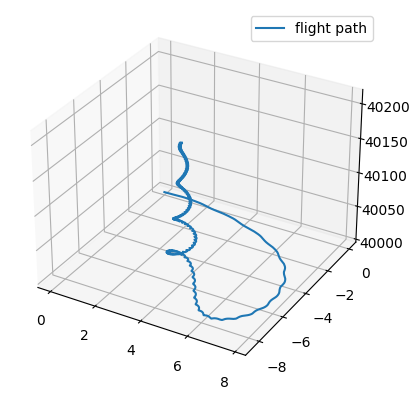

In [69]:
ax = plt.figure().add_subplot(projection='3d')

# Prepare arrays x, y, z
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
x,y,z = path[0,:], path[1,:], path[2,:]


ax.plot(x, y, z, label='flight path')
ax.legend()

plt.show()

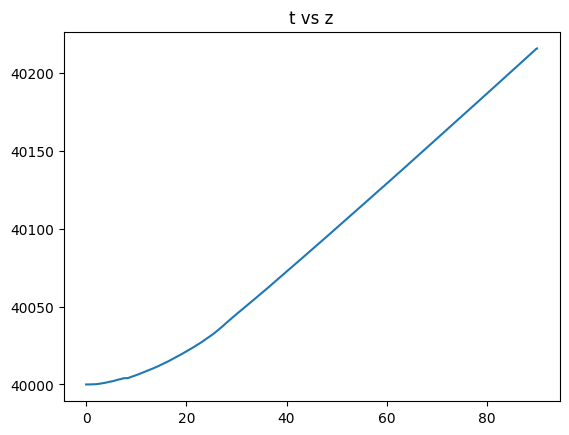

In [70]:
t = np.linspace(0,90,num = len(z))
plt.title("t vs z")
plt.plot(t,  z)
plt.show()